# 2 - Abstractions in decision making
This notebook is part of the supplementary material for:  
Genewein T., Leibfried F., Grau-Moya J., Braun D.A. (2015) *Bounded rationality, abstraction and hierarchical decision-making: an information-theoretic optimality principle*, Frontiers in Robotics and AI.  

More information on how to run the notebook on the accompanying [github repsitory](https://github.com/tgenewein/BoundedRationalityAbstractionAndHierarchicalDecisionMaking) where you can also find updated versions of the code and notebooks.

This notebook corresponds to Sections 2.2 - 2.4 and reproduces Figures 2, 3 and 4 of the paper.

## From free energy to rate distortion

In notebook 1, corresponding to Section 2.1 of the paper, we introduced a free energy framework for bounded rational decision making. Essentially we formalized a variational problem where we searched for a desired behavior $p^*(a|w)$ that maximizes expected utility while at the same time keeping computational cost low. The parameter $\beta$ (inverse temperature) governs the trade-off. Crucially, we only considered a single environment (or context) $w$.

Now, we will extend our problem to find bounded optimal behavior, for many different environments. Additionally, we also search for the best prior over actions (averaged over all environments). Formally, we extend the original variational problem by taking the average over environments and the arg max over the prior as well

$$\underset{p_0(a)}{\operatorname{arg~max}}~\sum_w p(w)~\left[\underset{p(a|w)}{\operatorname{arg~max}}~\mathbf{E}_{p(a|w)}[U(w,a)] - \frac{1}{\beta} D_{\mathrm{KL}}(p(a|w)||p_0(a))\right].$$

The problem can be rewritten as
$$\underset{p(a|w)}{\operatorname{arg~max}}\sum_{w,a}p(w,a)U(w,a) - \frac{1}{\beta}I(W;A),$$
which is mathematically identical to the optimization in rate-distortion theory (the information-theoretic framework for lossy compression). $I(W;A)$ denotes the mutual information between the random variables $W$ and $A$ and is computed as the average KL-divergence $I(W;A)=\sum_w p(w) \underbrace{\sum_a p(a|w) \log \frac{p(a|w)}{p(a)}}_{D_{\mathrm{KL}(p(a|w)||p(a)}}$

The problem has an analytical solution in the form of a set of self-consistent equations

$$\begin{align}
p^*(a|w) &= \frac{1}{Z(w)}p(a) \exp(\beta U(w,a))\\
p(a) &= \sum_w p(a|w) p(w)
\end{align}$$
with the partition sum $Z(w) = \sum_a p(a) \exp(\beta U(w,a))$


Similar to the free-energy case, the inverse temperature plays the role of a resource-parameter and governs the trade-off between large expected utility and low computational effort, measured by the mutual information term. For low $\beta$ and thus low computational resources, the average KL-divergence between the specific behavior $p^*(a|w)$ and the marginal (or average) behavior $p(a)$ must be small. This can only be achieved by applying the same or a similar policy to different $w$, which leads to behavioral abstractions where different situations elicit the same response. On the other hand, for large $\beta$ and thus large computational resources, specific behavior can deviate substantially from the average behavior, allowing for very different behavior for different $w$.

## Taxonomy example
The goal is to design a recommender system that observes an item bought $w$ and then recommends another item $a$. In this example the system can either recommend another concrete item or the best-selling item of a certain category or the best-selling item of a super-category which subsumes several categories. Recommending the correct concrete item will lead to the highest chances of buying and thus to the highest expected utility. Recommending the best-selling item of the corresponding category or super-category leads to a non-zero utility as well (with a lower value, but the same recommendation is applicable to multiple bought items). Below is a table of the super-categories and categories for each item - the corresponding item that has the highest chance of being bought when recommending is indicated with the arrow ``->``
 * Electric devices and electronics
   * Computers
     * Laptop -> laptop-sleeve
     * Monitor -> monitor cable
     * Game pad -> video game
   * Small appliances
     * Coffee machine -> coffee capsules
     * Vaccuum cleaner -> vaccuum cleaner bags
     * Electric toothbrush -> brush heads
 * Food and Cooking
   * Fruit
     * Grapes -> cheese
     * Strawberries -> cream
     * Limes -> cane sugar
   * Baking
     * Pancake mix -> maple syrup
     * Baking soda -> vinegar
     * Baker's yeast -> flour
     * Muffin cups -> chocolate chips, flour

The example is summarized in the plot of the utility function $U(a,w)$ below.

### [Interact] change the utility function/task (requires some work)
...in principle you can use any of the examples presented in the paper (also from Section 3 or 4) by loading it from the correct ``.jl`` file. However, you might want to change axis-labeling etc. accordingly which requires a bit of work.

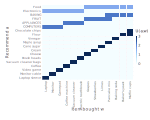

In [1]:
using RateDistortionDecisionMaking, Gadfly
#make the default plot size a bit larger
set_default_plot_size(15cm, 12cm)

#set up taxonomy example --- use other examples by including corresponding file here
include("TaxonomyExample.jl")
w_vec, w_strings, a_vec, a_strings, p_w, U = setuptaxonomy()

#pre-compute utilities, find maxima
U_pre, Umax = setuputilityarrays(a_vec, w_vec,U)

#visualize utility
plt_utility = visualizeMatrix(U_pre, w_vec, a_vec, w_strings, a_strings, xlabel="Item bought w",
                              ylabel="Recommend a", legendlabel="U(a,w)")

### [Interact] Set inverse temperature $\beta$
Set the inverse temperature below to a value $\geq 0$. The inverse temperature governs the computational resources (because it sets the price of information processing that is traded off against the expected utility). Low values of $\beta$ correspond to low computational resources and will lead to quite abstract solutions (in the sense that the same policy is used on many different $w$). High values of $\beta$ will in contrast lead to very $w$-specific actions as there is little cost for adapting to the different world-states $w$. 

The parameter you set here will be used in the code-cells below, so when changing it make sure to re-run all the cells.

In [2]:
β = 1.3 #inverse temperature

1.3

## Finding $p^*(a|w)$ through Blahut-Arimoto iterations
The solutions $p^*(a|w)$ and $p(a)$ can be obtained by initializing randomly and then iterating the equations until convergence. This is known as the Blahut-Arimoto algorithm. It is guaranteed to converge to the global solution of the rate distortion variational problem.

In [3]:
ε = 0.00001 #convergence critetion for BAiterations
maxiter = 10000 #maximum number of BA iterations

#initialize p(a) uniformly
num_acts = length(a_vec)
pa_init = ones(num_acts)/num_acts 

#Blahut-Arimotot iterations
p_agw, p_a, performance = BAiterations(pa_init, β, U_pre, p_w, ε, maxiter, compute_performance=true, 
                                       performance_as_dataframe=true, performance_per_iteration=false)


#visualize solution
#suppress immediate plotting since the stacked plots look bad, rather use display() to show each plot separately
plot_marg, plot_cond = visualizeBAsolution(p_a, p_agw, a_vec, w_vec, a_strings, w_strings,
                                           wlabel="Item bought w", alabel="Recommend a",
                                           legendlabel_marginal="p(a)", legendlabel_conditional="p*(a|w)",suppress_vis=true);
display(plot_marg)
display(plot_cond)


<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Laptop sleeve 
 Monitor cable 
 Video game 
 Coffee 
 Vacuum cleaner bags 
 Brush heads 
 Cheese 
 Cream 
 Cane sugar 
 Maple syrup 
 Vinegar 
 Flour 
 Chocolate chips 
 COMPUTERS 
 APPLIANCES 
 FRUIT 
 BAKING 
 Electronics 
 Food 
 
 
 Recommend a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Item bought w 
 
 
 Laptop 
 Monitor 
 Gamepad 
 Coffee machine 
 Vacuum cleaner 
 Electric toothbrush 
 Grapes 
 Strawberries 
 Limes 
 Pancake mix 
 Baking soda 
 Baker's yeast 
 Muffin cups 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Laptop sleeve 
 Monitor cable 
 Video game 
 Coffee 
 Vacuum cleaner bags 
 Brush heads 
 Cheese 
 Cream 
 Cane sugar 
 Maple syrup 
 Vinegar 
 Flour 
 Chocolate chips 
 COMPUTERS 
 APPLIANCES 
 FRUIT 
 BAKING 
 Electronics 
 Food 
 
 
 Recommend a

Try changing the value of $\beta$ in the code above and re-run the code-cells to see how the bounded-optimal solution changes. You can notice that over a certain range of $\beta$ values, the solution does not seem to change much but then suddenly a small change in $\beta$ leads to a drastic change in the solution. These phase-transitions are a result of the sharp structure of the utility function - we will take a closer look below.

## Sweep over $\beta$ values to see the different levels of abstraction emerge
Note that the code below might take a few minutes to run - you can speed it up by using a lower-resolution $\beta$-grid: ``β_sweep``

We will now sweep over a whole range of $\beta$-values and record the corresponding expected utility and information terms (as well as the value of the objective function that trades-off utility and information processing cost). We can then use this to plot the terms as a function of $\beta$ and make the phase-transitions visible.

In [4]:
#β-sweep
ε = 0.00001 #convergence critetion for BAiterations
maxiter = 20000
β_sweep = [0.01:0.005:3]
#β_sweep = [0.1:0.05:2, 2:0.5:15]

nβ = length(β_sweep)

#preallocate
I = zeros(nβ)
Ha = zeros(nβ)
Hagw = zeros(nβ)
EU = zeros(nβ)
RDobj = zeros(nβ)

#sweep over β values
for i=1:nβ    
    pagw, pa, I[i], Ha[i], Hagw[i], EU[i], RDobj[i] = BAiterations(pa_init, β_sweep[i], U_pre,  p_w, ε, maxiter,compute_performance=true)  
end

#plot evolution of performance measures
plot_perf_entropy, plot_perf_util, plot_rateutility = plotperformancemeasures(I, Ha, Hagw, EU, RDobj, β_sweep);

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 β 
 
 
 
 
 RU_obj 
 
 
 
 
 
 
 
 E[U] 
 
 
 
 
 
 
 
 
 
 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 5.1 
 5.2 
 5.3 
 5.4 
 5.5 
 5.6 
 5.7 
 5.8 
 5.9 
 6.0 
 -3 
 0 
 3 
 6 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M18.96,80.83 L 19.17 80.83 19.38 80.83 19.58 80.83 19.79 80.83 20 80.83 20.21 80.83 20.41 80.83 20.62 80.83 20.83 80.83 21.04 80.83 21.24 80.83 21.45 80.83 21.66 80.83 21.87 80.83 22.07 80.83 22.28 80.83 22.49 80.82 22.7 80.81 22.9 80.79 23.11 80.77 23.32 80.75 23.52 80.73 23.73 80.71 23.94 80.69 24.15 80.67 24.35 80.65 24.56 80.63 24.77 80.61 24.98 80.59 25.18 80.57 25.39 80.55 25.6 80.53 25.81 80.51 26.01 80.49 26.22 80.47 26.43 80.45 26.64 80.43 26.84 80.41 27.05 80.39 27.26 80.37 27.47 80.35 27.67 80.33 27.88 80.31 28.09 80.29 28.3 80.27 28.5 80.25 28.71 80.23 28.92 80.21 29.13 80.19 29.33 80.17 29.54 80.15 29.75 80.13 29.95 80.11 30.16 80.09 30.37 80.07 30.58 80.05 30.78 80.03 30.99 80.01 31.2 79.99 31.41 79.97 31.61 79.95 31.82 79.93 32.03 79.91 32.24 79.89 32.44 79.87 32.65 79.85 32.86 79.84 33.07 79.82 33.27 79.8 33.48 79.78 33.69 79.76 33.9 79.74 34.1 79.72 34.31 79.7 34.52 79.68 34.73 79.66 34.93 79.65 35.14 79.63 35.35 79.61 35.56 79.59 35.76 79.57 35.97 79.55 36.18 79.53 36.38 79.52 36.59 79.5 36.8 79.48 37.01 79.46 37.21 79.44 37.42 79.42 37.63 79.41 37.84 79.39 38.04 79.37 38.25 79.35 38.46 79.33 38.67 79.32 38.87 79.3 39.08 79.28 39.29 79.26 39.5 79.24 39.7 79.23 39.91 79.21 40.12 79.19 40.33 79.17 40.53 79.16 40.74 79.14 40.95 79.12 41.16 79.1 41.36 79.09 41.57 79.07 41.78 79.05 41.99 79.04 42.19 79.02 42.4 79 42.61 78.99 42.82 78.97 43.02 78.95 43.23 78.94 43.44 78.92 43.64 78.9 43.85 78.89 44.06 78.87 44.27 78.85 44.47 78.84 44.68 78.82 44.89 78.8 45.1 78.79 45.3 78.77 45.51 78.75 45.72 78.74 45.93 78.72 46.13 78.7 46.34 78.67 46.55 78.62 46.76 78.57 46.96 78.52 47.17 78.47 47.38 78.4 47.59 78.31 47.79 78.22 48 78.13 48.21 78.04 48.42 77.95 48.62 77.85 48.83 77.76 49.04 77.67 49.25 77.58 49.45 77.5 49.66 77.46 49.87 77.43 50.07 77.4 50.28 77.37 50.49 77.34 50.7 77.31 50.9 77.28 51.11 77.25 51.32 77.22 51.53 77.19 51.73 77.16 51.94 77.14 52.15 77.11 52.36 77.08 52.56 77.05 52.77 77.02 52.98 77 53.19 76.97 53.39 76.94 53.6 76.92 53.81 76.89 54.02 76.86 54.22 76.84 54.43 76.81 54.64 76.78 54.85 76.76 55.05 76.73 55.26 76.7 55.47 76.68 55.68 76.65 55.88 76.63 56.09 76.6 56.3 76.58 56.5 76.55 56.71 76.53 56.92 76.5 57.13 76.48 57.33 76.45 57.54 76.43 57.75 76.4 57.96 76.38 58.16 76.36 58.37 76.33 58.58 76.3 58.79 75.44 58.99 75.4 59.2 75.37 59.41 7

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 I(A;W) [bits] 
 
 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 -5 
 0 
 5 
 10 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M128.28,7.12 L 128.28 7.13 128.27 7.13 128.26 7.13 128.25 7.13 128.24 7.13 128.23 7.14 128.22 7.14 128.22 7.14 128.21 7.14 128.2 7.14 128.19 7.15 128.18 7.15 128.17 7.15 128.16 7.15 128.15 7.16 128.14 7.16 128.13 7.16 128.12 7.16 128.11 7.16 128.1 7.17 128.09 7.17 128.07 7.17 128.06 7.17 128.05 7.18 128.04 7.18 128.03 7.18 128.02 7.19 128.01 7.19 127.99 7.19 127.98 7.19 127.97 7.2 127.96 7.2 127.94 7.2 127.93 7.21 127.92 7.21 127.91 7.21 127.89 7.22 127.88 7.22 127.87 7.22 127.85 7.23 127.84 7.23 127.82 7.23 127.81 7.24 127.79 7.24 127.78 7.24 127.76 7.25 127.75 7.25 127.73 7.25 127.72 7.26 127.7 7.26 127.69 7.27 127.67 7.27 127.65 7.27 127.64 7.28 127.62 7.28 127.6 7.29 127.59 7.29 127.57 7.3 127.55 7.3 127.53 7.3 127.52 7.31 127.5 7.31 127.48 7.32 127.46 7.32 127.44 7.33 127.42 7.33 127.4 7.34 127.38 7.34 127.36 7.35 127.34 7.35 127.32 7.36 127.3 7.36 127.28 7.37 127.26 7.37 127.23 7.38 127.21 7.39 127.19 7.39 127.17 7.4 127.14 7.4 127.12 7.41 127.1 7.42 127.07 7.42 127.05 7.43 127.02 7.44 127 7.44 126.97 7.45 126.95 7.46 126.92 7.46 126.9 7.47 126.87 7.48 126.84 7.48 126.82 7.49 126.79 7.5 126.76 7.51 126.73 7.51 126.7 7.52 126.67 7.53 126.64 7.54 126.61 7.54 126.58 7.55 126.55 7.56 126.52 7.57 126.49 7.58 126.46 7.59 126.43 7.6 126.4 7.6 126.36 7.61 126.33 7.62 126.3 7.63 126.26 7.64 126.23 7.65 126.19 7.66 126.16 7.67 126.12 7.68 126.08 7.69 126.05 7.7 126.01 7.71 125.97 7.72 125.93 7.73 125.89 7.74 125.85 7.76 125.81 7.77 125.77 7.78 125.73 7.79 125.69 7.8 125.65 7.81 125.61 7.83 125.56 7.84 125.52 7.85 125.48 7.86 125.43 7.88 125.39 7.89 125.34 7.9 125.29 7.92 125.25 7.93 125.2 7.94 125.15 7.96 125.1 7.97 125.05 7.99 125 8 124.95 8.02 124.9 8.03 124.85 8.05 124.8 8.06 124.74 8.08 124.69 8.1 124.63 8.11 124.58 8.13 124.52 8.14 124.47 8.16 124.41 8.18 124.35 8.2 124.29 8.21 124.23 8.23 124.17 8.25 124.11 8.27 124.05 8.29 123.99 8.31 123.92 8.33 123.86 8.35 123.79 8.37 123.73 8.39 123.66 8.41 123.59 8.43 123.53 8.45 123.46 8.47 123.39 8.49 123.32 8.52 123.24 8.54 123.17 8.56 123.1 8.58 123.02 8.61 122.95 8.63 122.87 8.66 122.8 8.68 122.72 8.71 122.64 8.73 122.56 8.76 122.48 8.78 122.4 8.81 122.31 8.84 122.23 8.86 122.14 8.89 122.06 8.92 121.97 8.95 121.88 8.98 121.79 9.01 121.7 9.03 121.61 9.06 121.52 9.1 121.43 9.13 121.33 9.16 121.24 9.19 121.14 9.22 121.04 9.25 120.94 9.29 120.84 9.32 120.74 9.36 120.64 9.39 120.54 9.43 120.43 9.46 120.32 9.5 120.22 9.53 120.11 9.57 120 9.61 119.89 9.65 119.77 9.69 119.66 9.73 119.55 9.77 119.43 9.81 119.31 9.85 119.19 9.89 119.07 9.93 118.95 9.97 118.83 10.02 118.7 10.06 118.57 10.11 118.45 10.15 118.32 10.2 118.19 10.24 118.05 10.29 117.92 10.34 117.79 10.39 117.65 10.44 117.51 10.49 117.37 10.54 117.23 10.59 117.09 10.64 116.94 10.69 116.8 10.75 116.65 10.8 116.5 10.8

In the first two panels we see how the information processing effort $I(W;A)=H(A)-H(A|W)$ evolves with increasing $\beta$. Importantly, we see sharp kinks on all curves, this is where the phase-transitions occur. We see similar kinks in the second panel that shows the expected utility and the value of the objective function. Each kink corresponds to a different level of abstraction (to investigate set $\beta$ in the first code-block after the utility function and run the subsequent two code-cells).
The third panel shows the rate-utility curve (in analogy to the rate-distortion curve from information theory). It shows the required computational capacity to achieve a certain utility and vice versa (the maxmally achievable utility, given certain information processing capabilities). The shaded region indicates theoretically impossible systems that cannot be achieved, regardless of the implementation. The white region denotes suboptimal systems that do not use their computational capacity maximally. The line indicates optimal systems (that solve the rate-distortion variational problem as given in the equations above).

# Plots for the paper

In [5]:
#create a plot where the entropic performance plot is shown and on top of it several solutions of p(a|w)
#for different tempereatures (ideally lying in the plateaus)

β_plts = [0.05, 0.5, 0.9, 1.1, 1.3, 1.5, 2]

nβ = length(β_plts)

#preallocate
I = zeros(nβ)
Ha = zeros(nβ)
Hagw = zeros(nβ)
EU = zeros(nβ)
RDobj = zeros(nβ)
plots = Array(Plot,nβ)

for i=1:nβ    
    pagw, pa, I[i], Ha[i], Hagw[i], EU[i], RDobj[i] = BAiterations(pa_init, β_plts[i], U_pre, p_w, ε, maxiter,compute_performance=true)  

    #except for the last plot, provide an optional argument that will be passed on to the underlying Gadfly Theme()
    #to suppress drawing of the colorkey (legend)
    β_val = β_plts[i]
    if i==1
        pcond = visualizeBAconditional(pagw, a_vec, w_vec, wlabel="Item bought w β=$β_val", alabel="Recommend a", 
        legendlabel="", key_position = :none, minor_label_font_size = 0pt,  major_label_font_size = 9pt,
        bar_spacing = 0pt)
    elseif i<nβ
        pcond = visualizeBAconditional(pagw, a_vec, w_vec, wlabel="β=$β_val", alabel="",
        legendlabel="", key_position = :none,  minor_label_font_size = 0pt,  major_label_font_size = 9pt,
        bar_spacing = 0pt)
    else
        pcond = visualizeBAconditional(pagw, a_vec, w_vec, wlabel="β=$β_val", alabel="",
        legendlabel="p*(a|w)",  minor_label_font_size = 0pt, major_label_font_size = 9pt,
        key_title_font_size = 9pt, key_label_font_size = 8pt, bar_spacing = 0pt )
    end

    #display(pcond)
    plots[i] = pcond
end

#compose final plot
plot_evolution = vstack(hstack(plots...),plot_perf_entropy)
display(plot_evolution)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 β 
 
 
 
 
 H(A|W) 
 
 
 
 
 
 
 
 H(A) 
 
 
 
 
 
 
 
 I(A;W) 
 
 
 
 
 
 
 
 
 
 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 5.1 
 5.2 
 5.3 
 5.4 
 5.5 
 5.6 
 5.7 
 5.8 
 5.9 
 6.0 
 -3 
 0 
 3 
 6 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M18.96,86.4 L 19.17 86.4 19.38 86.4 19.58 86.4 19.79 86.4 20 86.4 20.21 86.4 20.41 86.4 20.62 86.4 20.83 86.4 21.04 86.4 21.24 86.4 21.45 86.4 21.66 86.4 21.87 86.4 22.07 86.4 22.28 86.4 22.49 86.4 22.7 86.4 22.9 86.4 23.11 86.4 23.32 86.39 23.52 86.39 23.73 86.39 23.94 86.38 24.15 86.38 24.35 86.38 24.56 86.38 24.77 86.37 24.98 86.37 25.18 86.37 25.39 86.36 25.6 86.36 25.81 86.35 26.01 86.35 26.22 86.35 26.43 86.34 26.64 86.34 26.84 86.33 27.05 86.33 27.26 86.32 27.47 86.32 27.67 86.32 27.88 86.31 28.09 86.31 28.3 86.3 28.5 86.3 28.71 86.29 28.92 86.29 29.13 86.28 29.33 86.27 29.54 86.27 29.75 86.26 29.95 86.26 30.16 86.25 30.37 86.25 30.58 86.24 30.78 86.23 30.99 86.23 31.2 86.22 31.41 86.21 31.61 86.21 31.82 86.2 32.03 86.19 32.24 86.19 32.44 86.18 32.65 86.17 32.86 86.17 33.07 86.16 33.27 86.15 33.48 86.14 33.69 86.14 33.9 86.13 34.1 86.12 34.31 86.11 34.52 86.11 34.73 86.1 34.93 86.09 35.14 86.08 35.35 86.07 35.56 86.07 35.76 86.06 35.97 86.05 36.18 86.04 36.38 86.03 36.59 86.02 36.8 86.01 37.01 86.01 37.21 86 37.42 85.99 37.63 85.98 37.84 85.97 38.04 85.96 38.25 85.95 38.46 85.94 38.67 85.93 38.87 85.92 39.08 85.91 39.29 85.9 39.5 85.89 39.7 85.88 39.91 85.88 40.12 85.87 40.33 85.86 40.53 85.85 40.74 85.84 40.95 85.83 41.16 85.82 41.36 85.81 41.57 85.79 41.78 85.78 41.99 85.77 42.19 85.76 42.4 85.75 42.61 85.74 42.82 85.73 43.02 85.72 43.23 85.71 43.44 85.7 43.64 85.69 43.85 85.68 44.06 85.67 44.27 85.66 44.47 85.65 44.68 85.63 44.89 85.62 45.1 85.61 45.3 85.6 45.51 85.59 45.72 85.58 45.93 85.57 46.13 85.55 46.34 85.53 46.55 85.49 46.76 85.46 46.96 85.42 47.17 85.38 47.38 85.33 47.59 85.26 47.79 85.19 48 85.12 48.21 85.05 48.42 84.98 48.62 84.91 48.83 84.84 49.04 84.77 49.25 84.69 49.45 84.63 49.66 84.59 49.87 84.57 50.07 84.54 50.28 84.52 50.49 84.49 50.7 84.47 50.9 84.45 51.11 84.42 51.32 84.4 51.53 84.37 51.73 84.35 51.94 84.32 52.15 84.3 52.36 84.27 52.56 84.25 52.77 84.23 52.98 84.2 53.19 84.18 53.39 84.15 53.6 84.13 53.81 84.1 54.02 84.08 54.22 84.05 54.43 84.03 54.64 84 54.85 83.98 55.05 83.95 55.26 83.93 55.47 83.9 55.68 83.88 55.88 83.85 56.09 83.83 56.3 83.81 56.5 83.78 56.71 83.76 56.92 83.73 57.13 83.71 57.33 83.68 57.54 83.66 57.75 83.63 57.96 83.61 58.16 83.58 58.37 83.56 58.58 83.53 58.79 82.63 58.99 82.58 59.2 82.55 59.41 82.51 59.62 82.48 59.82 82.44 60.03 82.41 60.24 82.38 60.45 82.34 60.65 82.31 60.86 82.27 

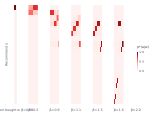

In [6]:
#uncomment to store plots

plot_setup = hstack(plt_utility, plot_cond)
#display(plot_setup)
#draw(SVG("Figures/TaskSetupAndExmplSolution_Taxonomy.svg",22cm,12cm),plot_setup)


plot_evolution_paper = vstack(plot_perf_util, plot_perf_entropy)
plot_solutions = hstack(plots...)
#display(plot_evolution_paper)
#display(plot_solutions)
#draw(SVG("Figures/TempSweepEvolution.svg", 18cm, 14cm), plot_evolution_paper)
#draw(SVG("Figures/TempSweepSolutions.svg", 18cm, 7cm), plot_solutions)

#display(plot_rateutility)
#draw(SVG("Figures/RateUtilityCurve.svg", 8.5cm, 7cm), plot_rateutility)